# Deep Learning a PDE with PINNs (Call Options)

The purpose of this notebook is to give an introduction to the Physics Informed Neural Network (PINN) method to solve PDEs. The present workbook is largely inspired by the excellent work or [J. Blechschmidt, O. G. Ernst](https://onlinelibrary.wiley.com/doi/full/10.1002/gamm.202100006). We use the notebook provided in this reference as base, and modify it to apply to the more Finance-related case of the Black-Scholes model.

The ultimate objective, and hope, is that Machine Learning based methods such as the PINNs may be able to beat the curse of dimensionality. While it is also the reason for our interest in the method, here we work only on the 1-dimensional case. The purpose is two-fold: to make the method easier to understand as an introduction to the subject, but also set up preliminary methods and get a feel, through experimentation, of how the method behaves and which neural networks work best in this simplest case, before hopefully studying more complicated (and multi-dimensional) cases.

We think of the PINNs as a generalization of the Meshfree method, see chapter 16 of 
[D. Duffy](https://www.amazon.com/Finite-Difference-Methods-Financial-Engineering/dp/0470858826). In the Meshfree method, the unknown function that is the solution of the PDE is approximated as an expansion over Radial Basis Functions (RBF) in the space direction. These functions have certain convenient properties, including being simple to evaluate, smooth, and allowing a large variety of shapes to be composed by combining them. Their differentials being known, the PDE can be applied to them analytically and resolving the PDE ends up being a (dense) matrix inversion. Thanks to the absence of space discretization, there is a hope that this method can beat the curve of dimensionality.

We have used Meshfree in the past, but unfortunately were not able to make it work in a practical fashion. It appears that the matrices that need to be inverted often suffer from poor condition number, and their numerical inversion becomes unstable. Although this might depend on the inversion algorithm, we also found that while the method in principle can beat the curve of dimensionality because the number of RBFs should increase less than exponentially with the dimension, effectively linear increases of the size of the matrix tend to require quickly increasing runtime.

The PINNs use a similar principle of expanding the unknown function on a set of basis function, but here what plays the role of the RBFs in Meshfree are simply the neurons (RBFs can be seen as a particular case of deep-learning algorithm). A difference that is certainly crucial here, is that the PINNs do not require a matrix inversion for their training, which can be done via one of the multiple variants of SGD (we use Adam). We find that the PINNs work in a much more stable fashion and across a wider range of parameters than the RBFs.

Here we use Black-Scholes as dynamics for a single asset, and value a call option on this asset. The workbook allows to play with a variety of parameters and observe their impact on the training and the accuracy on PV, Delta, Gamma and Theta by comparison to the Black-Scholes closed-forms. The Greeks on the PINN are estimated by Algorithmic Differentiation on the network (AD). The PINN resolution and its differentiation are performed using the TensorFlow/Keras framework.

We find that 2 layers of 4 neurons are sufficient for a pretty good accuracy on PV and Delta, with softplus and tanh activation functions leading to best results (accuracy vs speed of convergence). As often, we find that a decay of the learning rate can help stabilize the convergence of the loss function.

However, we have difficulty reaching good accuracy on Theta and Gamma. Increasing the size of the network does not seem to help but instead seems to lead to overfitting with strong oscillations. It remains to be seen with more experimentation if better configurations can be reached. For instance, we could consider different distributions of points in the dataset, focusing on certain areas of space-time, possibly other activation functions, optimizer types, etc...

In [1]:
# Import relevant modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time as tm
import scipy.stats
import sklearn as sk
from sklearn.metrics import mean_squared_error

print("TensorFlow version: " + tf.__version__)
print("Keras version: " + tf.keras.__version__)
print("NumPy version: " + np.__version__)
print("SciPy version: " + scipy.__version__)
print("SciKit version: " + sk.__version__)

TensorFlow version: 2.9.1
Keras version: 2.9.0
NumPy version: 1.23.1
SciPy version: 1.4.1
SciKit version: 0.23.2


## 1) Parameters and helper functions

Set up parameters for the stochastic model (spot, vol, etc...), the payoff (strike), the PDE and its PINN solver. Flags allow to choose whether the PDE is resolved on the spot variable or the log-moneyness. We also allow 2 types of scheduling for the evolution of the learning rate.

In [2]:
# Runtime configuration
show_points = True

# Payoff and model parameters
vol = 0.25
rate = 0.04
div = 0.01
expiry = 2.5
spot = 100.0
strike = 95

# PDE
use_log = True

# PINN parameters
num_final = 250 # Number of points for the payoff
nb = 200 # Number of points per side boundary
num_boundary = 2 * nb  # Total number of points on side boundaries
num_pde = 1 * 1000  # Number of points for the PDE
use_piecewise_schedule = False  # Piecewise or linearly decaying learning rate

# Random generator seed
seed = 42

In [3]:
# Black-Scholes closed-forms
def black_price(spot_, strike_, vol_, time_):
    spot_ = np.asarray(spot_, dtype='float64')
    df_r = np.exp(-rate * time_)
    df_div = np.exp(-div * time_)
    fwd_ = spot_ * df_div / df_r
    stdev_ = vol_ * np.sqrt(time_)
    d1 = np.log(fwd_ / strike_) / stdev_ + 0.5 * stdev_
    d2 = d1 - stdev_
    # df = np.exp(-rate * time_)
    N1 = N.cdf(d1)
    N2 = N.cdf(d2)
    phi1 = N.pdf(d1)

    pv = df_r * (fwd_ * N1 - strike_ * N2)
    delta = df_div * N1
    theta = -df_r * (rate * strike_ * N2 - div * fwd_ * N1 + phi1 * fwd_ * stdev_ / 2.0 / time_)
    gamma = df_div * phi1 / stdev_ / spot_

    return pv, delta, theta, gamma

# Create a grid of 2d points (t, x) from all combinations of t and x vectors
def make_grid(t_vec, x_vec):
    t_mat, x_mat = np.meshgrid(t_vec, x_vec)
    return np.vstack([t_mat.flatten(), x_mat.flatten()]).T

# Strip TensorFlow's .jacobian() into a series of Jacobian matrices per point
def strip_jacobian(jacobian):
    shape = jacobian.shape
    num_points = shape[0]
    dim = shape[1]
    stripped_jacobian = []
    for i in range(num_points):
        jac = jacobian[i]
        new_jac = []
        for j in range(dim):
            new_jac.append(jac[j][i].numpy())

        stripped_jacobian.append(new_jac)

    return stripped_jacobian

## 2) PINN learning

In this section we implement the PDE solving using a PINN. The main idea is to consider the resolution of the PDE as an optimization problem, where the loss function receives two contributions: the PDE (i.e. an equation with a 0 right-hand side) and its boundaries (i.e. a collection of payoff evaluations at points in space and time that are relevant to the problem).

The network's inputs are 2d points in time and space, which we draw as 2 different types: the inner points and the boundaries. The network's output is the derivative's PV as a function of time and space. That is, the network gives us the PV not just for spot at $t=0$ but for any point in time and at any value of the spot between $t=0$ and maturity.

The loss function is a combination of a PDE contribution, targetting 0, and a boundary contribution where the target PV is assumed to be known. This is typically the case of the payoff at maturity, which can be augmented by "side boundaries" at earlier times but with extreme values of the spot (in a very similar fashion to the standard Finite Difference Method).

We start by defining the set of inner and boundary points. Then we evaluate the target values (PV) on these boundaries. As the target values of the PDE points is 0, that is sufficient to construct our dataset. Next we set up a network, define the loss function, and finally train the network.

In [4]:
# Time boundaries at 0 and expiry
tmin = 0.0
tmax = expiry

# Spot boundaries defined as extreme percentiles of the distribution
N = scipy.stats.norm
fwd = spot * np.exp((rate - div) * expiry)
stdev = vol * np.sqrt(expiry)
conf = 0.99  # Chosen percentile of the distribution
percentile = N.ppf(conf)
xmin = -0.5 * stdev * stdev - percentile * stdev
xmax = -0.5 * stdev * stdev + percentile * stdev
smin = fwd * np.exp(xmin)
smax = fwd * np.exp(xmax)
if not use_log:
    xmin = smin
    xmax = smax

print("Min time: {:,.2f}".format(tmin))
print("Max time: {:,.2f}".format(tmax))
print("Min spot: {:,.2f}".format(smin))
print("Max spot: {:,.2f}".format(smax))
if use_log:
    print("Min red. spot: {:,.2f}".format(xmin))
    print("Max red. spot: {:,.2f}".format(xmax))

Min time: 0.00
Max time: 2.50
Min spot: 39.74
Max spot: 250.04
Min red. spot: -1.00
Max red. spot: 0.84


### a) Payoff and side boundaries

Specify the payoff at maturity and on the side boundaries. A scale can be introduced as it often helps convergence, but here we find that practically it brings no real advantage.

In [5]:
# ## Define functions to calculate the boundary values: final payoff and side boundaries.
scale = tf.constant(1.0)  # Using spot doesn't seem to help, so reverting to no scaling

# Call payoff at maturity
def payoff(x):
    if use_log:
        s = fwd * tf.math.exp(x)
    else:
        s = x

    return tf.math.maximum(s - strike, 0.0) / scale

# At low extreme values of the spot, the payoff is 0
def lw_boundary(t, x):
    n = x.shape[0]
    return tf.zeros((n, 1))

# At high extreme values of the spot, we assume the payoff to be the intrinsic value
def up_boundary(t, x):
    n = x.shape[0]
    if use_log:
        fwd_ = spot * tf.math.exp((rate - div) * t)
        s = fwd_ * tf.math.exp(x)
    else:
        s = x

    # Forward forward
    fwdfwd_ = s * tf.math.exp((rate - div) * (expiry - t))
    df_ = tf.math.exp(-rate * (expiry - t))

    return tf.ones((n, 1)) * df_ * (fwdfwd_ - strike) / scale

### b) Build the dataset

Calculate the values of the payoff and side boundary points, then package the whole dataset into 2 buckets: the inner points and the boundary points (payoff and side). Note that the number of each type of points can be tuned, and in particular we may omit to include any side boundaries (to test numerically).

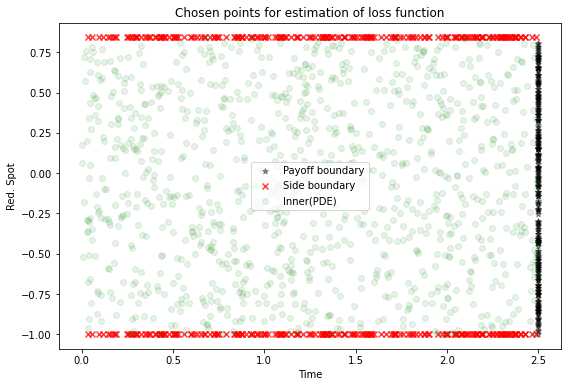

In [6]:
tf.random.set_seed(seed)

# Draw payoff points
t0 = tf.ones((num_final, 1)) * tmax
x0 = tf.random.uniform((num_final, 1), xmin, xmax)
payoff_points = tf.concat([t0, x0], axis=1)
payoff_values = payoff(x0)

# Draw side boundaries points
lw_tb = tf.random.uniform((nb, 1), tmin, tmax)
lw_xb = tf.ones((nb, 1)) * xmin
up_tb = lw_tb  # We could also draw another set
up_xb = tf.ones((nb, 1)) * xmax
tb = tf.concat([lw_tb, up_tb], axis=0)
xb = tf.concat([lw_xb, up_xb], axis=0)
side_points = tf.concat([tb, xb], axis=1)
lw_side_values = lw_boundary(lw_tb, lw_xb)
up_side_values = up_boundary(up_tb, up_xb)
side_values = tf.concat([lw_side_values, up_side_values], axis=0)

# Pack boundary points together (payoff and side)
if len(side_points) > 0:
    boundary_points = [payoff_points, side_points]
    boundary_values = [payoff_values, side_values]
else:
    boundary_points = [payoff_points]
    boundary_values = [payoff_values]

# Draw PDE points
tpde = tf.random.uniform((num_pde, 1), tmin, tmax)
xpde = tf.random.uniform((num_pde, 1), xmin, xmax)
pde_points = tf.concat([tpde, xpde], axis=1)

# Illustrate chosen points
if show_points:
    fig = plt.figure(figsize=(9, 6))
    plt.scatter(t0, x0, c='black', marker='*', alpha=0.4, label="Payoff boundary")
    plt.scatter(tb, xb, c='red', marker='x', alpha=0.75, label="Side boundary")
    plt.scatter(tpde, xpde, c='green', marker='o', alpha=0.10, label="Inner(PDE)")
    plt.xlabel('Time')
    plt.ylabel('Red. Spot')
    plt.title('Chosen points for estimation of loss function')
    plt.legend(loc='center')
    plt.show()

### c) Prepare the Keras model

Now we set up the network architecture, leaving it essentially the same as what was chosen in our source material [J. Blechschmidt, O. G. Ernst](https://onlinelibrary.wiley.com/doi/full/10.1002/gamm.202100006). Right after the 2d input layer, a scaling layer is introduced to map the input data to the interval $(-1, 1)$. Then a number of hidden layers and a 1d output layer are added.

In [7]:
kinits = tf.keras.initializers
klayers = tf.keras.layers

# Bounds in vector form (for input scaling)
lb = tf.constant([tmin, xmin])
ub = tf.constant([tmax, xmax])

def add_hidden_layer(model_, neurons_, activation_):
    init = kinits.glorot_normal

    model_.add(klayers.Dense(neurons_, activation=activation_, kernel_initializer=init,
                            use_bias=True, bias_initializer=kinits.Constant(0.1)))
    

# Set up the network architecture
def compose_model(hidden_layers_, num_neurons_):
    model_ = tf.keras.Sequential()

    # 2d inputs
    model_.add(tf.keras.Input(2))

    # Scaling layer to map the inputs to (-1, 1)
    model_.add(klayers.Lambda(lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0))

    # Hidden layers
    for hl in hidden_layers_:
        add_hidden_layer(model_, num_neurons_, hl)

    # 1d outputs
    model_.add(klayers.Dense(1))

    return model_

### d) Calculate the loss function

The loss function is composed of 2 contributions coming from the inner PDE and the boundaries. The PDE can be resolved in its original form on the spot $S$ as

\begin{equation}
\frac{\partial u}{\partial t} + (r - q) S \frac{\partial u}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 u}{\partial S^2} - r u = 0 
\end{equation} 

or on the log-moneyness $X$ defined by $S_t = F(0,t)e^{X_t}$, in which case the PDE becomes

\begin{equation}
\frac{\partial u}{\partial t} -\frac{1}{2}\sigma^2 \frac{\partial u}{\partial X} + \frac{1}{2}\sigma^2 \frac{\partial^2 u}{\partial X^2} - r u = 0.
\end{equation}

In the above $q$ is the dividend rate and $F(0,t) = S_0e^{(r-q)t}$ is the forward.

In [8]:
# Loss and gradient calculations
def calculate_pde(model_, pde_points_):
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = pde_points_[:, 0:1], pde_points_[:, 1:2]

        # Variables t and x are watched during tape to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Calculate function
        u = model_(tf.stack([t[:, 0], x[:, 0]], axis=1))

        # Compute gradient u_x within the GradientTape since we need the second derivatives
        u_x = tape.gradient(u, x)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    # Calculate residual of the Black-Scholes PDE
    ito = 0.5 * vol * vol
    if use_log:
        return u_t -ito * u_x + ito * u_xx - rate * u
    else:
        return u_t + (rate - div) * x * u_x + ito * x * x * u_xx - rate * u


def calculate_loss(model_, pde_points_, boundary_points_, boundary_values_):
    # PDE contribution
    pde_r = calculate_pde(model_, pde_points_)
    pde_loss = tf.reduce_mean(tf.square(pde_r))

    # Initialize loss
    loss_ = pde_loss

    # Add boundary contributions
    for i_ in range(len(boundary_points_)):
        u_pred = model_(boundary_points_[i_])
        loss_ += tf.reduce_mean(tf.square(boundary_values_[i_] - u_pred))

    return loss_


def calculate_loss_grad(model_, pde_points_, boundary_points_, boundary_values_):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model_.trainable_variables)
        loss_ = calculate_loss(model_, pde_points_, boundary_points_, boundary_values_)

    g = tape.gradient(loss_, model_.trainable_variables)
    del tape

    return loss_, g

### e) Compose the model

Here we choose the structure of the model namely its number of layers, number of neurons, activation functions, we specify the learning rate schedule and the optimizer, and finally define a training step.

In [9]:
# Initialize model and set up the optimizer
# Tested activations: tanh, softplus, softmax, relu, selu, elu, sigmoid
hidden_layers = ['softplus', 'softplus']  # 1 entry per hidden layer
num_neurons = 4

model = compose_model(hidden_layers, num_neurons)

# Learning rate and its decay
if use_piecewise_schedule:
    # Over the steps [0, s1] use lr1, then [s1, s2] use lr2 and
    # lr3 beyond s2 in ([s1, s2], [lr1, lr2, lr3])
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 5000], [1e-2, 5e-3, 1e-4])
    decay = 0.0 # Makes the lr decrease gradually over each interval
else:
    lr = 1e-1  # Best 1e-2
    decay = 0.0001  # Best 0.0001  # Makes the lr decrease gradually


# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay)


# Define the training step
@tf.function
def train_step():
    # Compute current loss and gradient
    loss_, grad_theta = calculate_loss_grad(model, pde_points, boundary_points, boundary_values)

    # Apply gradient descent
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss_

### f) Network Greeks by AD

As the inputs to the network are time and spot and its output is PV, we can obtain delta, theta and gamma by differentiating the network's output with respect to its inputs, using TensorFlow AD. TensorFlow's .jacobian() method is used to get the second derivatives on 2d points, but one could also consider splitting along the dimensions and apply .gradient() twice.

In [10]:
# Calculate network's differentials by AD
def diff_model(model_, points):
    tf_points = tf.convert_to_tensor(points)
    with tf.GradientTape() as tape1:
        tape1.watch(tf_points)
        with tf.GradientTape() as tape2:
            tape2.watch(tf_points)
            pv = model_(tf_points)
    
        grad = tape2.gradient(pv, tf_points)

    jacob = tape1.jacobian(grad, tf_points)

    pv = pv.numpy()[:, 0] * scale
    grad = grad.numpy() * scale
    stripped_jacobian = strip_jacobian(jacob)
    scaled_jacobian = stripped_jacobian * scale

    pv = pv.numpy()
    delta = grad[:, 1].numpy()
    theta = grad[:, 0].numpy()
    gamma = scaled_jacobian[:, 1, 1]

    # Recombine if using the log coordinates
    if use_log:
        time_ = points[:, 0]
        x_ = points[:, 1]
        fwd_ = spot * np.exp((rate - div) * time_)
        spot_ = fwd_ * np.exp(x_)
        delta = delta / spot_
        gamma = (gamma - spot_ * delta) / (spot * spot)
        theta = theta - (rate - div) * spot_ * delta

    return [pv, delta, theta, gamma]

# Test at t = 0, x = spot
if use_log:
    x_pred = make_grid(expiry, [np.log(90/spot), np.log(100/spot), np.log(110/spot)])
else:
    x_pred = make_grid(expiry, [90, 100, 110])
values = diff_model(model, x_pred)
# print(values)
print("PV: {:,.4f}".format(values[0][0]))
print("Delta: {:,.4f}".format(values[1][0]))
print("Theta: {:,.4f}".format(values[2][0]))
print("Gamma: {:,.4f}".format(values[3][0]))

PV: -1.0619
Delta: 0.0043
Theta: 0.0510
Gamma: -0.0001


## 3) Training

Here we launch the training. Loss and learning rate are recorded for later display. At each epoch, we go through the whole set of points to optimize the loss function. This step can be re-executed multiple times to increase convergence. So long as the keras model is not re-initialized, we can come back here and the training will restart where it left off.

In [11]:
# Training parameters
num_epochs = 10 * 1000

# Record loss and learning rate
loss_hist = []
lr_hist = []
bs_rmse_hist = []

# Test set with Black-Scholes at t = 0
x_space_ = np.linspace(xmin, xmax, 100)
t_ = 0.0
if use_log:
    fwd_t = spot * np.exp((rate - div) * t_)
    s_space_ = fwd_t * np.exp(x_space_)
else:
    s_space_ = x_space_

x_pred = make_grid(t_, x_space_)
pv_cf, d_cf, t_cf, g_cf = black_price(s_space_, strike, vol, expiry - t_)

# Start the training
t0 = tm.time()
for i in range(num_epochs + 1):
    lr = optim._decayed_lr(tf.float32).numpy()
    loss = train_step()
    loss_hist.append(loss.numpy())
    lr_hist.append(lr)

    # Every 50 epochs, display loss, learning rate and rmse to Black-Scholes
    if i % 50 == 0:
        pv = model(x_pred) * scale
        rmse = np.sqrt(sk.metrics.mean_squared_error(pv_cf, pv))
        print('Epoch {c:4,}/{h:,}: loss={a:10.4e}, '.format(h=num_epochs, c=i, a=loss), end="")
        print('lr={b:.6f}, rmse to BS={d:.6f}'.format(b=lr, d=rmse))

print("")
print('Runtime: {:.3f} seconds'.format(tm.time() - t0))

Epoch    0/10,000: loss=1.4125e+04, lr=0.100000, rmse to BS=53.762251
Epoch   50/10,000: loss=3.4120e+02, lr=0.099502, rmse to BS=18.203045
Epoch  100/10,000: loss=5.1804e+01, lr=0.099010, rmse to BS=4.870292
Epoch  150/10,000: loss=3.2010e+01, lr=0.098522, rmse to BS=5.666561
Epoch  200/10,000: loss=2.5870e+01, lr=0.098039, rmse to BS=5.282430
Epoch  250/10,000: loss=2.1610e+01, lr=0.097561, rmse to BS=4.655611
Epoch  300/10,000: loss=1.7831e+01, lr=0.097087, rmse to BS=3.950129
Epoch  350/10,000: loss=1.4677e+01, lr=0.096618, rmse to BS=3.206493
Epoch  400/10,000: loss=1.2373e+01, lr=0.096154, rmse to BS=2.557738
Epoch  450/10,000: loss=1.0764e+01, lr=0.095694, rmse to BS=2.061432
Epoch  500/10,000: loss=9.5830e+00, lr=0.095238, rmse to BS=1.690076
Epoch  550/10,000: loss=8.6793e+00, lr=0.094787, rmse to BS=1.410560
Epoch  600/10,000: loss=7.9827e+00, lr=0.094340, rmse to BS=1.205763
Epoch  650/10,000: loss=7.4443e+00, lr=0.093897, rmse to BS=1.061440
Epoch  700/10,000: loss=7.0182e+

Epoch 5,600/10,000: loss=6.5858e-01, lr=0.064103, rmse to BS=0.152744
Epoch 5,650/10,000: loss=6.5267e-01, lr=0.063898, rmse to BS=0.153244
Epoch 5,700/10,000: loss=6.5533e-01, lr=0.063694, rmse to BS=0.422875
Epoch 5,750/10,000: loss=6.5050e-01, lr=0.063492, rmse to BS=0.150161
Epoch 5,800/10,000: loss=6.3974e-01, lr=0.063291, rmse to BS=0.153438
Epoch 5,850/10,000: loss=6.3427e-01, lr=0.063091, rmse to BS=0.153756
Epoch 5,900/10,000: loss=6.2888e-01, lr=0.062893, rmse to BS=0.154259
Epoch 5,950/10,000: loss=6.2352e-01, lr=0.062696, rmse to BS=0.154825
Epoch 6,000/10,000: loss=6.1819e-01, lr=0.062500, rmse to BS=0.155362
Epoch 6,050/10,000: loss=6.1550e-01, lr=0.062305, rmse to BS=0.277082
Epoch 6,100/10,000: loss=6.1737e-01, lr=0.062112, rmse to BS=0.157833
Epoch 6,150/10,000: loss=6.0514e-01, lr=0.061920, rmse to BS=0.155697
Epoch 6,200/10,000: loss=5.9993e-01, lr=0.061728, rmse to BS=0.156198
Epoch 6,250/10,000: loss=5.9477e-01, lr=0.061538, rmse to BS=0.156505
Epoch 6,300/10,000: 

## 4) Comparison with Closed-Form

We draw ladders along the spot direction for PV, Delta, Theta and Gamma, and compare with the Black-Scholes closed-form. We also take a look at the loss history to inspect for lack of convergence, evidence of overfitting, etc...

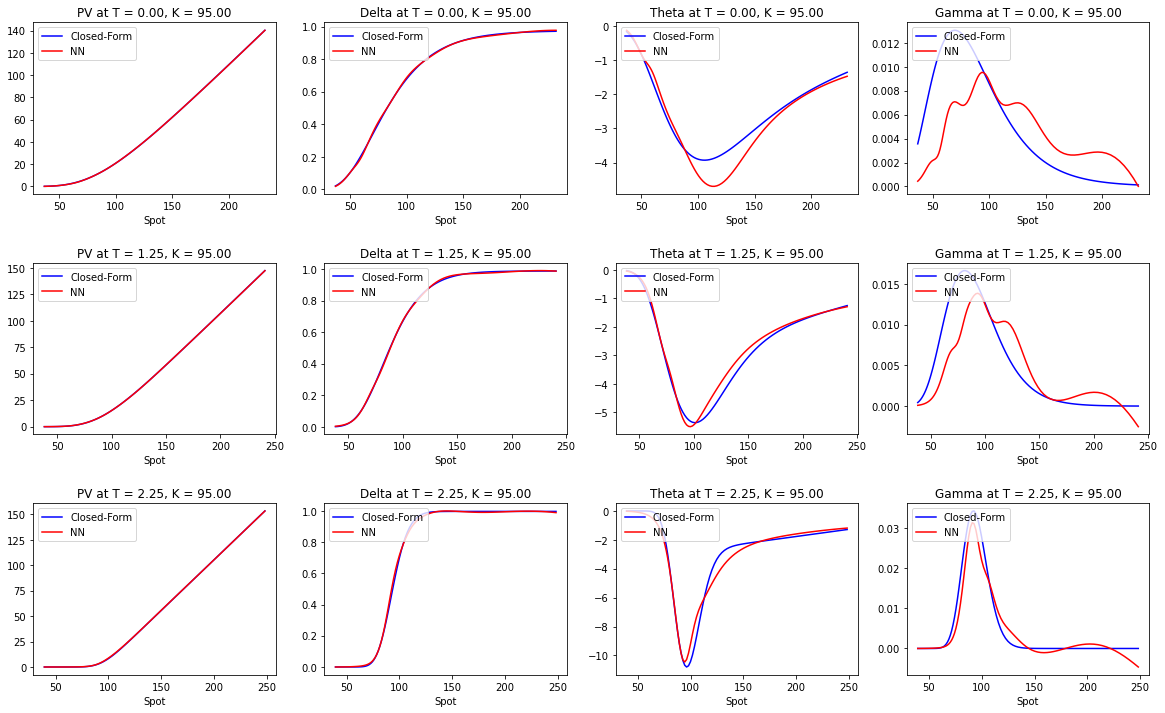

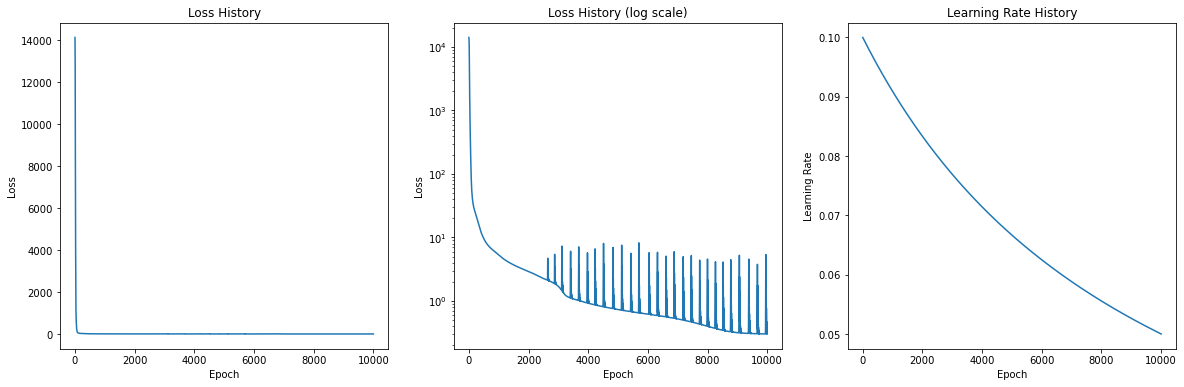

In [12]:
# #### Plot solution
def plot_slice(n_points_, t_, xmin_, xmax_, greek_idx, plt_idx):
    x_space_ = np.linspace(xmin_, xmax_, n_points_)
    if use_log:
        fwd_t = spot * np.exp((rate - div) * t_)
        s_space_ = fwd_t * np.exp(x_space_)
    else:
        s_space_ = x_space_

    x_pred = make_grid(t_, x_space_)
    y_pred = diff_model(model, x_pred)
    pv_cf, delta_cf, theta_cf, gamma_cf = black_price(s_space_, strike, vol, expiry - t_)
    # PV
    plt.subplot(3, 4, plt_idx)
    plt.title("PV at T = {a:.2f}, K = {b:.2f}".format(a=t_, b=strike))
    plt.xlabel('Spot')
    plt.plot(s_space_, pv_cf, color='blue', label='Closed-Form')
    plt.plot(s_space_, y_pred[0], color='red', label='NN')
    plt.legend(loc='upper left')
    # Delta
    plt.subplot(3, 4, plt_idx + 1)
    plt.title("Delta at T = {a:.2f}, K = {b:.2f}".format(a=t_, b=strike))
    plt.xlabel('Spot')
    plt.plot(s_space_, delta_cf, color='blue', label='Closed-Form')
    plt.plot(s_space_, y_pred[1], color='red', label='NN')
    plt.legend(loc='upper left')
    # Theta
    plt.subplot(3, 4, plt_idx + 2)
    plt.title("Theta at T = {a:.2f}, K = {b:.2f}".format(a=t_, b=strike))
    plt.xlabel('Spot')
    plt.plot(s_space_, theta_cf, color='blue', label='Closed-Form')
    plt.plot(s_space_, y_pred[2], color='red', label='NN')
    plt.legend(loc='upper left')
    # Gamma
    plt.subplot(3, 4, plt_idx + 3)
    plt.title("Gamma at T = {a:.2f}, K = {b:.2f}".format(a=t_, b=strike))
    plt.xlabel('Spot')
    plt.plot(s_space_, gamma_cf, color='blue', label='Closed-Form')
    plt.plot(s_space_, y_pred[3], color='red', label='NN')
    plt.legend(loc='upper left')


# Plot PV charts
n_points = 100
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.40)
plot_slice(n_points, 0.00 * expiry, xmin, xmax, 0, 1)
plot_slice(n_points, 0.50 * expiry, xmin, xmax, 0, 5)
plot_slice(n_points, 0.90 * expiry, xmin, xmax, 0, 9)

# Plot loss history
plt.figure(figsize=(20, 6))
plt.subplots_adjust(hspace=0.40)
plt.subplot(1, 3, 1)
plt.title("Loss History")
plt.plot(range(len(loss_hist)), loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 3, 2)
plt.title("Loss History (log scale)")
plt.plot(range(len(loss_hist)), loss_hist)
plt.yscale("log")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 3, 3)
plt.title("Learning Rate History")
plt.plot(range(len(lr_hist)), lr_hist)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()